In [13]:
import pandas as pd

df = pd.read_csv("/home/hp/results/MOUSE/distance_analysis_data.csv")
print("Columns in the CSV:", df.columns.tolist())

Columns in the CSV: ['Mutation', 'Mean_dG_star', 'Mean_dG0', 'dG_star_raw', 'dG0_raw', 'Level', 'name', 'sec49_distance', 'ca_distance']


Arial font not found. For best PLOS ONE compliance, consider:
- Linux: sudo apt-get install ttf-mscorefonts-installer
- Mac: Arial should be pre-installed
- Windows: Arial should be pre-installed
- Alternative: Install Liberation Sans or use default system font
Using fallback font: DejaVu Sans
Figure saved as comprehensive_mutation_analysis.png and comprehensive_mutation_analysis.pdf


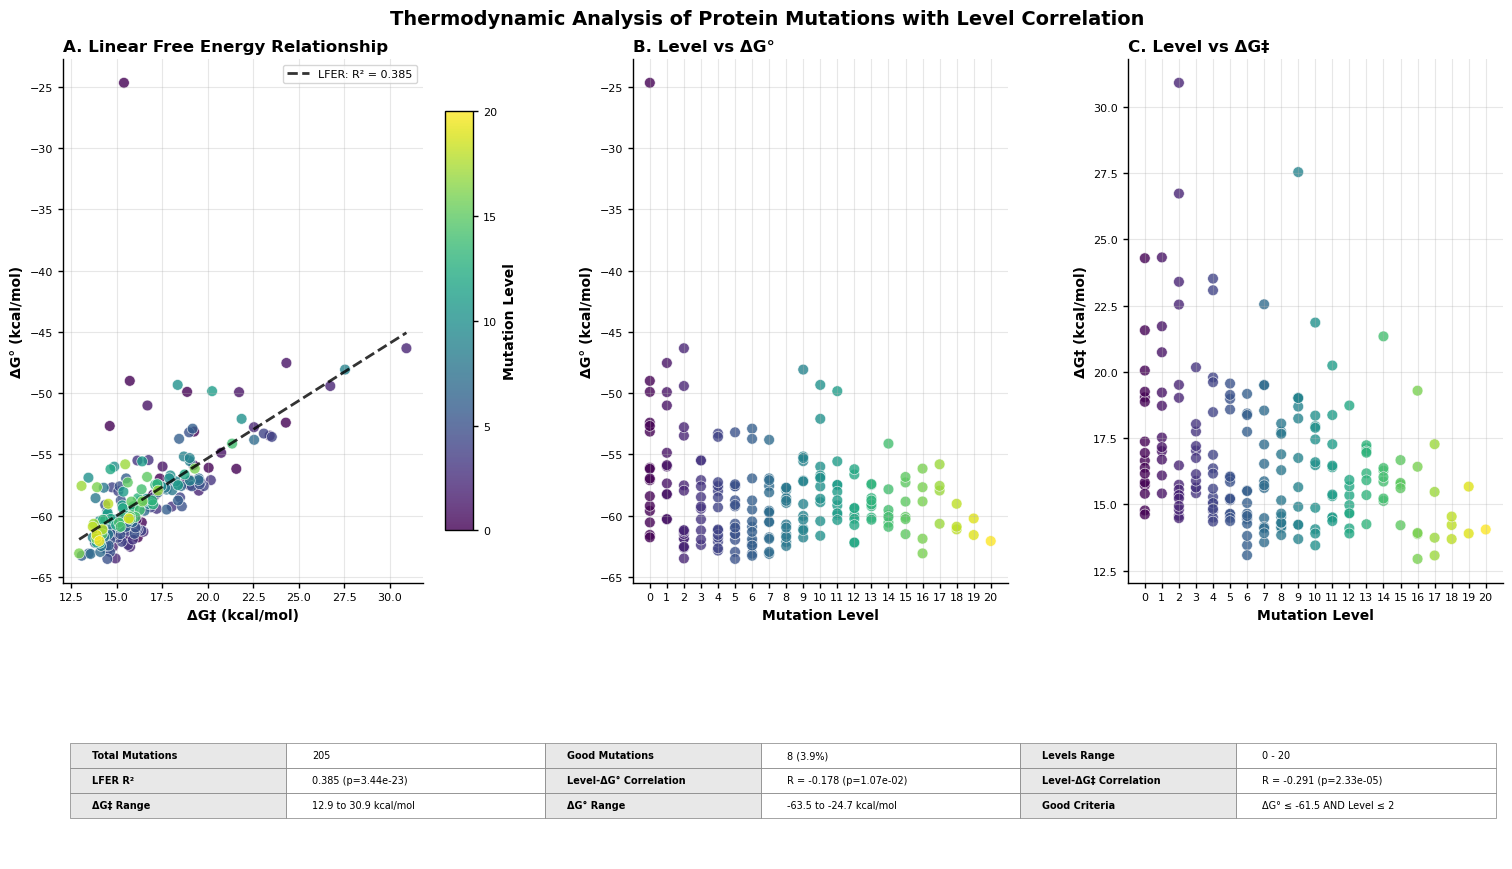


FIGURE LEGEND FOR MANUSCRIPT:

    Figure 1. Thermodynamic analysis of protein mutations with level correlation.

    (A) Linear Free Energy Relationship (LFER) between ΔG‡ and ΔG°. Points are 
    colored by mutation level as shown in the colorbar. Dashed line shows LFER 
    with correlation coefficient.

    (B,C) Mutation level effects on ΔG° and ΔG‡ respectively. Points are colored 
    by level using the same color scale as panel A.

    Statistical summary shows correlations between mutation levels and 
    thermodynamic parameters, along with LFER analysis.

    Good mutations are defined as those in the bottom 20% for both ΔG° and 
    mutation level. Energy values in kcal/mol.
    

Dataset summary:
Number of mutations: 205
Level range: 0 - 20
Unique levels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.in

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import seaborn as sns
import matplotlib.font_manager as fm
from scipy import stats

def normalize_data(data):
    """
    Normalize data to 0-1 range using min-max normalization
    Replaces sklearn's MinMaxScaler
    
    Parameters:
    -----------
    data : numpy.ndarray
        Data to normalize
    
    Returns:
    --------
    numpy.ndarray
        Normalized data with values between 0 and 1
    """
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    
    # Avoid division by zero
    data_range = data_max - data_min
    data_range[data_range == 0] = 1
    
    return (data - data_min) / data_range

def check_arial_font():
    """Check if Arial font is available and provide installation guidance"""
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    arial_variants = ['Arial', 'Arial Unicode MS', 'Arial Black']
    
    arial_available = any(font in available_fonts for font in arial_variants)
    
    if not arial_available:
        print("Arial font not found. For best PLOS ONE compliance, consider:")
        print("- Linux: sudo apt-get install ttf-mscorefonts-installer")
        print("- Mac: Arial should be pre-installed")
        print("- Windows: Arial should be pre-installed")
        print("- Alternative: Install Liberation Sans or use default system font")
        return False
    else:
        print("Arial font is available")
        return True

def setup_plos_style():
    """Configure matplotlib for PLOS ONE journal standards"""
    # Check Arial availability first
    arial_available = check_arial_font()
    
    # Set font family with fallbacks
    if arial_available:
        rcParams['font.family'] = 'Arial'
    else:
        # Use best available alternative
        available_fonts = [f.name for f in fm.fontManager.ttflist]
        fallback_fonts = ['DejaVu Sans', 'Liberation Sans', 'Helvetica', 'sans-serif']
        
        for font in fallback_fonts:
            if font in available_fonts:
                rcParams['font.family'] = font
                print(f"Using fallback font: {font}")
                break
        else:
            rcParams['font.family'] = 'sans-serif'
            print("Using default sans-serif font")
    
    # PLOS ONE compliant font sizes
    rcParams['font.size'] = 8
    rcParams['axes.labelsize'] = 10
    rcParams['axes.titlesize'] = 12
    rcParams['xtick.labelsize'] = 8
    rcParams['ytick.labelsize'] = 8
    rcParams['legend.fontsize'] = 8
    rcParams['figure.titlesize'] = 14
    rcParams['axes.linewidth'] = 1.0
    rcParams['xtick.major.width'] = 1.0
    rcParams['ytick.major.width'] = 1.0
    rcParams['xtick.minor.width'] = 0.5
    rcParams['ytick.minor.width'] = 0.5
    rcParams['savefig.dpi'] = 300
    rcParams['savefig.bbox'] = 'tight'
    rcParams['savefig.pad_inches'] = 0.1

def create_plos_analysis(csv_path, save_path=None):
    """
    Create PLOS ONE compliant figure for mutation analysis with LFER and level analysis
    
    Parameters:
    -----------
    csv_path : str
        Path to CSV file containing mutation data
    save_path : str, optional
        Path to save the figure (saves as high-res PNG and PDF)
    """
    
    # Setup PLOS ONE styling
    setup_plos_style()
    
    # Load and validate data
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"Could not find file: {csv_path}")
    
    # Standardize column names
    column_mapping = {
        'Mean_dG_star': 'dg_star',
        'Mean_dG0': 'dg0', 
        'Mutation': 'mutation',
        'mean_dg_star': 'dg_star',
        'mean_dg0': 'dg0'
    }
    
    for old_name, new_name in column_mapping.items():
        if old_name in df.columns:
            df = df.rename(columns={old_name: new_name})
    
    # Validate required columns
    required_cols = {'dg_star', 'dg0', 'mutation', 'Level'}
    missing_cols = required_cols - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Clean and sort data
    df = df.dropna(subset=list(required_cols))
    df_sorted = df.sort_values('Level').reset_index(drop=True)
    
    # Define "good" mutations (lower is better for both metrics)
    # Use more stringent criteria: bottom 20% for both dG0 and Level
    dg0_threshold = df_sorted['dg0'].quantile(0.2)
    level_threshold = df_sorted['Level'].quantile(0.2)
    
    # Good mutations must be good in BOTH metrics
    good_mutations = (df_sorted['dg0'] <= dg0_threshold) & (df_sorted['Level'] <= level_threshold)
    
    # Create figure with simplified layout
    fig = plt.figure(figsize=(16, 10), facecolor='white')
    
    # Create custom grid layout - simplified to remove panels D, E, F
    gs = fig.add_gridspec(2, 3, height_ratios=[2, 0.6], width_ratios=[1.2, 1, 1],
                         hspace=0.35, wspace=0.3, left=0.06, right=0.96, 
                         top=0.92, bottom=0.12)
    
    # Main plots
    ax1 = fig.add_subplot(gs[0, 0])  # LFER plot with colorbar
    ax2 = fig.add_subplot(gs[0, 1])  # Level vs dG0
    ax3 = fig.add_subplot(gs[0, 2])  # Level vs dG_star
    ax4 = fig.add_subplot(gs[1, :])  # Statistics table
    
    # Panel A: Linear Free Energy Relationship (LFER) with colorbar
    # Calculate LFER (correlation between dG_star and dG0)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_sorted['dg_star'], df_sorted['dg0'])
    
    # Ensure levels are integers (convert if needed)
    df_sorted['Level'] = df_sorted['Level'].astype(int)
    
    # Create scatter plot colored by Level with colorbar
    scatter = ax1.scatter(df_sorted['dg_star'], df_sorted['dg0'],
                         c=df_sorted['Level'], s=60, alpha=0.8, 
                         edgecolors='white', linewidth=0.5,
                         cmap='viridis', vmin=0, vmax=20)
    
    # Add colorbar for levels with discrete ticks
    cbar = plt.colorbar(scatter, ax=ax1, shrink=0.8, aspect=15)
    cbar.set_label('Mutation Level', fontweight='bold', fontsize=10)
    cbar.ax.tick_params(labelsize=8)
    
    # Set discrete ticks for levels 0-20
    unique_levels = sorted(df_sorted['Level'].unique())
    if len(unique_levels) <= 10:
        cbar.set_ticks(unique_levels)
    else:
        # If too many levels, show every 2nd or 5th level
        step = 2 if len(unique_levels) <= 20 else 5
        cbar.set_ticks(range(0, 21, step))
    
    # Add LFER line
    x_range = np.array([df_sorted['dg_star'].min(), df_sorted['dg_star'].max()])
    y_pred = slope * x_range + intercept
    ax1.plot(x_range, y_pred, 'k--', alpha=0.8, linewidth=2, 
             label=f'LFER: R² = {r_value**2:.3f}')
    
    ax1.set_xlabel('ΔG‡ (kcal/mol)', fontweight='bold')
    ax1.set_ylabel('ΔG° (kcal/mol)', fontweight='bold')
    ax1.set_title('A. Linear Free Energy Relationship', fontweight='bold', loc='left')
    ax1.legend(loc='best', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Panel B: Level vs ΔG°
    scatter2 = ax2.scatter(df_sorted['Level'], df_sorted['dg0'],
                          c=df_sorted['Level'], s=60, alpha=0.8,
                          edgecolors='white', linewidth=0.5,
                          cmap='viridis', vmin=0, vmax=20)
    
    # Set integer ticks on x-axis
    ax2.set_xticks(range(int(df_sorted['Level'].min()), int(df_sorted['Level'].max()) + 1))
    ax2.set_xlabel('Mutation Level', fontweight='bold')
    ax2.set_ylabel('ΔG° (kcal/mol)', fontweight='bold')
    ax2.set_title('B. Level vs ΔG°', fontweight='bold', loc='left')
    ax2.grid(True, alpha=0.3)
    
    # Panel C: Level vs ΔG‡
    scatter3 = ax3.scatter(df_sorted['Level'], df_sorted['dg_star'],
                          c=df_sorted['Level'], s=60, alpha=0.8,
                          edgecolors='white', linewidth=0.5,
                          cmap='viridis', vmin=0, vmax=20)
    
    # Set integer ticks on x-axis
    ax3.set_xticks(range(int(df_sorted['Level'].min()), int(df_sorted['Level'].max()) + 1))
    
    ax3.set_xlabel('Mutation Level', fontweight='bold')
    ax3.set_ylabel('ΔG‡ (kcal/mol)', fontweight='bold')
    ax3.set_title('C. Level vs ΔG‡', fontweight='bold', loc='left')
    ax3.grid(True, alpha=0.3)
    
    # Panel D: Statistics table (now at bottom)
    ax4.axis('off')
    
    # Calculate additional statistics
    level_dg0_corr = stats.pearsonr(df_sorted['Level'], df_sorted['dg0'])
    level_dgstar_corr = stats.pearsonr(df_sorted['Level'], df_sorted['dg_star'])
    
    stats_data = [
        ['Total Mutations', f'{len(df_sorted)}'],
        ['Good Mutations', f'{good_mutations.sum()} ({good_mutations.sum()/len(df_sorted)*100:.1f}%)'],
        ['Levels Range', f'{int(df_sorted["Level"].min())} - {int(df_sorted["Level"].max())}'],
        ['LFER R²', f'{r_value**2:.3f} (p={p_value:.2e})'],
        ['Level-ΔG° Correlation', f'R = {level_dg0_corr[0]:.3f} (p={level_dg0_corr[1]:.2e})'],
        ['Level-ΔG‡ Correlation', f'R = {level_dgstar_corr[0]:.3f} (p={level_dgstar_corr[1]:.2e})'],
        ['ΔG‡ Range', f'{df_sorted["dg_star"].min():.1f} to {df_sorted["dg_star"].max():.1f} kcal/mol'],
        ['ΔG° Range', f'{df_sorted["dg0"].min():.1f} to {df_sorted["dg0"].max():.1f} kcal/mol'],
        ['Good Criteria', f'ΔG° ≤ {dg0_threshold:.1f} AND Level ≤ {int(level_threshold)}']
    ]
    
    # Create table with more columns to fit the data better
    n_cols = 3
    n_rows = len(stats_data) // n_cols + (1 if len(stats_data) % n_cols else 0)
    
    # Reshape data for table
    table_data = []
    labels = []
    for i in range(0, len(stats_data), n_cols):
        row_data = []
        row_labels = []
        for j in range(n_cols):
            if i + j < len(stats_data):
                row_labels.append(stats_data[i + j][0])
                row_data.append(stats_data[i + j][1])
            else:
                row_labels.append('')
                row_data.append('')
        table_data.append(row_data)
        labels.append(row_labels)
    
    # Flatten for table creation
    flat_data = []
    for i in range(len(table_data)):
        label_row = labels[i]
        data_row = table_data[i]
        combined_row = []
        for j in range(n_cols):
            combined_row.extend([label_row[j], data_row[j]])
        flat_data.append(combined_row)
    
    table = ax4.table(cellText=flat_data,
                     cellLoc='left',
                     loc='center',
                     colWidths=[0.15, 0.18] * n_cols)
    
    table.auto_set_font_size(False)
    table.set_fontsize(7)
    table.scale(1, 1.5)
    
    # Style the table
    for i in range(len(flat_data)):
        for j in range(n_cols * 2):
            cell = table[(i, j)]
            if j % 2 == 0:  # Parameter names
                cell.set_facecolor('#E8E8E8')
                cell.set_text_props(weight='bold')
            else:  # Values
                cell.set_facecolor('white')
            cell.set_edgecolor('gray')
            cell.set_linewidth(0.5)
    
    # Add overall title
    fig.suptitle('Thermodynamic Analysis of Protein Mutations with Level Correlation', 
                 fontsize=14, fontweight='bold', y=0.97)
    
    # Clean up all subplots
    for ax in [ax1, ax2, ax3]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Save figure if path provided
    if save_path:
        plt.savefig(f"{save_path}.png", dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        plt.savefig(f"{save_path}.pdf", bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"Figure saved as {save_path}.png and {save_path}.pdf")
    
    plt.show()
    
    return fig, (ax1, ax2, ax3, ax4)

def create_figure_legend():
    """
    Create a comprehensive figure legend following PLOS ONE guidelines
    """
    legend_text = """
    Figure 1. Thermodynamic analysis of protein mutations with level correlation.
    
    (A) Linear Free Energy Relationship (LFER) between ΔG‡ and ΔG°. Points are 
    colored by mutation level as shown in the colorbar. Dashed line shows LFER 
    with correlation coefficient.
    
    (B,C) Mutation level effects on ΔG° and ΔG‡ respectively. Points are colored 
    by level using the same color scale as panel A.
    
    Statistical summary shows correlations between mutation levels and 
    thermodynamic parameters, along with LFER analysis.
    
    Good mutations are defined as those in the bottom 20% for both ΔG° and 
    mutation level. Energy values in kcal/mol.
    """
    return legend_text

# Example usage with error handling
def main():
    """Main function to run the analysis"""
    csv_path = "/home/hp/results/MOUSE/distance_analysis_data.csv"
    save_path = "comprehensive_mutation_analysis"
    
    try:
        fig, axes = create_plos_analysis(csv_path, save_path)
        
        # Print legend for copy-paste into manuscript
        print("\n" + "="*60)
        print("FIGURE LEGEND FOR MANUSCRIPT:")
        print("="*60)
        print(create_figure_legend())
        
        # Print some basic statistics
        df = pd.read_csv(csv_path)
        print(f"\nDataset summary:")
        print(f"Number of mutations: {len(df)}")
        if 'Level' in df.columns:
            print(f"Level range: {int(df['Level'].min())} - {int(df['Level'].max())}")
            print(f"Unique levels: {sorted(df['Level'].astype(int).unique())}")
        
    except Exception as e:
        print(f"Error creating figure: {e}")
        print("Please check your data file and column names.")

if __name__ == "__main__":
    main()